## Load Data

In [2]:
import pandas as pd
import numpy as np
import os
import CRPS.CRPS as pscore
import copy
from joblib import dump, load
from scipy.stats import nbinom, poisson
from time import sleep
from tqdm import tqdm
import warnings

# create the feature- and actuals-data list
# set the feature and actuals year lists
feature_years = ['2017','2018','2019','2020']
actual_years = ['2018','2019','2020','2021']

actuals_df_list = []
features_df_list = []

# path to the current directory
current_dir = os.getcwd()

for i in range(len(feature_years)):
    # relative paths to the parquet files
    relative_path_features = os.path.join('..', 'data', 'cm_features_to_oct' + feature_years[i] + '.parquet')
    relative_path_actuals = os.path.join('..', 'data', 'cm_actuals_' + actual_years[i] + '.parquet')

    path_features = os.path.join(current_dir, relative_path_features)
    path_actuals = os.path.join(current_dir, relative_path_actuals)

    # append datasets to the lists
    actuals_df_list.append({'year':actual_years[i], 'data':pd.read_parquet(path_actuals, engine='pyarrow')})
    features_df_list.append({'year':feature_years[i], 'data':pd.read_parquet(path_features, engine='pyarrow')})

# concat the feature datasets, so that every data contains the observations starting with january 1990
for i in range(1,len(features_df_list)):
    features_df_list[i]['data'] = pd.concat([features_df_list[i-1]['data'], features_df_list[i]['data']])

country_list = sorted(features_df_list[3]['data'].index.get_level_values('country_id').unique().tolist())

# country group list of all four datasets
country_feature_group_list = []
country_actual_group_list = []
# fill list 
for i in range(len(features_df_list)):
    country_feature_group_list.append(features_df_list[i]['data'].groupby('country_id'))
    country_actual_group_list.append(actuals_df_list[i]['data'].groupby('country_id'))

In [3]:
# check for nan's
for featurelist in features_df_list:
    is_na_series = featurelist['data'].isna().sum()

    for i in range(len(is_na_series)):
        if is_na_series[i] > 0 :
            print(str(is_na_series.index[i]) + ': ' + str(is_na_series[i]))

# wichtig:
analog zur baseline code implementieren, der abfängt, dass auch für jedes Land der letzte Monat vor Jan 2018 verfügbar ist und insgesamt genug Monate vorhanden sind, um mit w_max den train, valid, test Split zu machen

z.b. 246 viel zu wenig Monate für w = 48?!

## Neural Net

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.losses import Loss
import matplotlib.pyplot as plt
import seaborn as sns

# crps loss function 
def crps(y_true, S):
    """
    Computes continuous ranked probability score:

    Parameters
    ----------
    y_true : tf tensor of shape (BATCH_SIZE, 1)
        True values.
    S : tf tensor of shape (BATCH_SIZE, N_SAMPLES)
        Predictive samples.

    Returns
    -------
    tf tensor of shape (BATCH_SIZE,)
        Scores.

    """
    beta=1
    n_samples = S.shape[-1]
    def expected_dist(diff, beta):
        return K.sum(K.pow(K.sqrt(K.square(diff)+K.epsilon()), beta),axis=-1) #axis = -1: last dimension <=> N_SAMPLES
    es_1 = expected_dist(y_true - S, beta)
    es_2 = 0
    for i in range(n_samples):
        es_2 = es_2 + expected_dist(K.expand_dims(S[:,i]) - S, beta)
    return es_1/n_samples - es_2/(2*n_samples**2)

class CRPSLoss(Loss):
    def call(self, y_true, S):
        return crps(y_true, S)

In [5]:
### prediction task for country 223 and actual year 2018
prediction_year = '2018'
dataset_index = actual_years.index(prediction_year)
prediction_country_id = 223

## load datasets
feature_data = country_feature_group_list[dataset_index].get_group(prediction_country_id)
actual_data = country_actual_group_list[dataset_index].get_group(prediction_country_id)

# numbers of months from the feature dataset
month_list_feature_data = feature_data.index.get_level_values('month_id').tolist()
first_month = month_list_feature_data[0]
last_month = month_list_feature_data[-1]



## hyperparameters
w_max = 48 # maximum number of months used for one training run





## split data in train-, validation- and test-dataset
# length of the maximum rolling window and the used "unreal" acutals starting 3 months after the last used month
roll_estim_window_len = w_max + 2 + 12 

# training dataset
last_month_train = last_month - w_max - 12-2-w_max 
data_train = feature_data.loc[(slice(first_month, last_month_train), slice(None)), :] # including "unreal" actuals

# validation dataset
last_month_valid = last_month - w_max
data_validate = feature_data.loc[(slice(last_month_train+1, last_month_valid), slice(None)), :] # including "unreal" actuals

# test dataset
data_test = feature_data.loc[(slice(last_month_valid+1, last_month), slice(None)), :] # no "unreal" actuals and real actuals not included as well


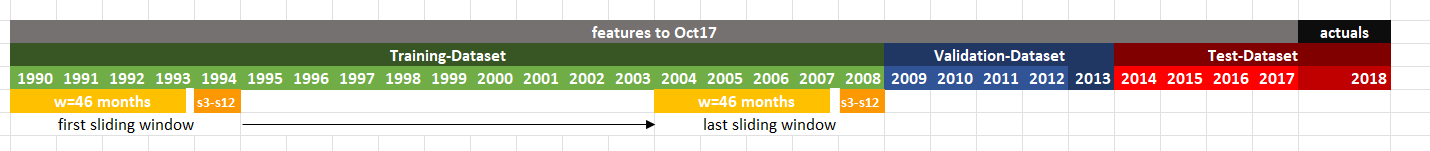

### neural net

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow_probability as tfp
tfd = tfp.distributions
tf.compat.v2.enable_v2_behavior()
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam


from scipy.stats import nbinom






#final Dense layer has 2 units. n must be positive -> softplus activation function
# p must be between 0 and 1 -> sigmoid activation function
def negative_binomial_layer(x):
    """
    Lambda function for generating negative binomial parameters
    n and p from a Dense(2) output.
    Assumes tensorflow 2 backend.
    
    Usage
    -----
    outputs = Dense(2)(final_layer)
    distribution_outputs = Lambda(negative_binomial_layer)(outputs)
    
    Parameters
    ----------
    x : tf.Tensor
        output tensor of Dense layer
        
    Returns
    -------
    out_tensor : tf.Tensor
        
    """
    
    # Get the number of dimensions of the input
    num_dims = len(x.get_shape())
    
    # Separate the parameters
    n, p = tf.unstack(x, num=2, axis=-1)
    
    # Add one dimension to make the right shape
    n = tf.expand_dims(n, -1)
    p = tf.expand_dims(p, -1)
        
    # Apply a softplus to make positive
    n = tf.keras.activations.softplus(n)
    
    # Apply a sigmoid activation to bound between 0 and 1
    p = tf.keras.activations.sigmoid(p)

    # Join back together again
    out_tensor = tf.concat((n, p), axis=num_dims-1)

    return out_tensor


def nBinom_sample_layer(x):
    """
    Lambda function for generating samples from the
    negative binomial parameters n and p from a tensor with dimension 2.
    Assumes tensorflow 2 backend.
    
    Usage
    -----
    outputs = tf.Tensor
    emp_sample_ouput = Lambda(nBinom_quantile_layer)(outputs)
    
    Parameters
    ----------
    x : tf.Tensor
        output tf.Tensor
        
    Returns
    -------
    out_tensor : tf.Tensor
        
    """
    
    

    # Get the number of dimensions of the input
    num_dims = len(x.get_shape())
    
    # Separate the parameters
    n, p = tf.unstack(x, num=2, axis=-1)
    
    # Add one dimension to make the right shape
    n = tf.expand_dims(n, -1)
    p = tf.expand_dims(p, -1)

    # transform quantiles to tensor
    #quantiles = tf.constant(quantiles)

    negative_binomial_dist = tfd.NegativeBinomial(total_count=n, probs=p)

    # calculate the quantiles
    sample = negative_binomial_dist.sample(tf.constant(10000))

    # Transpose to get the desired shape (1, 10000)
    sample = tf.squeeze(sample, axis=-1)
    sample = tf.transpose(sample)


    """ quantiles = np.arange(0.001, 0.9999, 0.001)
    quantiles = [round(q, 3) for q in quantiles] # due to binary inaccuracies

    # Convert n and p to scalar NumPy arrays
    n = n.numpy()
    p = p.numpy()


    sample = tf.constant(nbinom.ppf(quantiles, n, p))
    sample = tf.expand_dims(sample, axis=0) """


    return sample






def negative_binomial_loss(y_true, y_pred):
    """
    Negative binomial loss function.
    Assumes tensorflow backend.
    
    Parameters
    ----------
    y_true : tf.Tensor
        Ground truth values of predicted variable.
    y_pred : tf.Tensor
        n and p values of predicted distribution.
        
    Returns
    -------
    nll : tf.Tensor
        Negative log likelihood.
    """

    # Separate the parameters
    n, p = tf.unstack(y_pred, num=2, axis=-1)
    
    # Add one dimension to make the right shape
    n = tf.expand_dims(n, -1)
    p = tf.expand_dims(p, -1)
    
    # Calculate the negative log likelihood
    nll = (
        tf.math.lgamma(n) 
        + tf.math.lgamma(y_true + 1)
        - tf.math.lgamma(n + y_true)
        - n * tf.math.log(p)
        - y_true * tf.math.log(1 - p)
    )                  

    return nll


number_features = 10
len_features = 32

input_shape = (number_features*len_features,) # Number of used features   10 * 32
# z.B.
""" [
  [1, 2, 3, ..., 10],   # Datenpunkt 1 mit 10 features
  [11, 12, 13, ..., 20],  # Datenpunkt 2 mit 10 features
  ...
  [311, 312, 313, ..., 320]  # Datenpunkt 32 mit 10 features
] """


# Define inputs with predefined shape
inputs = Input(shape=input_shape)

# print(inputs.shape) -> (None, 10, 32) no Batch size defined (more flexible)

hidden_layer1 = Dense(200, activation='relu')(inputs) 
# Dense Layer: the 10 neurons in the dense layer get their source of input data 
# from all the other neurons of the previous layer of the network (= fully connected layer)
#hidden_layer2 = Dense(8, activation='relu')(hidden_layer1) 

# Predict the parameters of a negative binomial distribution
output_s3 = Dense(2)(hidden_layer1) # neurons for n and p
dist_output_s3 = Lambda(negative_binomial_layer)(output_s3) # n and p are transformed, so that they fulfill the constraints

sample_output_s3 = Lambda(nBinom_sample_layer)(dist_output_s3) # generate 999 quantiles from the distribution (needed for the crps loss)

# Construct model
model = Model(inputs=inputs, outputs=sample_output_s3)
#model = Model(inputs=inputs, outputs=dist_output_s3)

# Compile the model with the desired optimizer, loss function, etc.
model.compile(optimizer=Adam(learning_rate=0.001), loss=CRPSLoss())
#model.compile(optimizer=Adam(learning_rate=0.001), loss=negative_binomial_loss)


# Print model summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320)]             0         
                                                                 
 dense (Dense)               (None, 200)               64200     
                                                                 
 dense_1 (Dense)             (None, 2)                 402       
                                                                 
 lambda (Lambda)             (None, 2)                 0         
                                                                 
 lambda_1 (Lambda)           (None, 10000)             0         
                                                                 
Total params: 64602 (252.35 KB)
Trainable params: 64602 (252.35 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
from sklearn import model_selection, preprocessing

used_features = feature_data.iloc[:,2:12].tail(32)
used_features_norm = preprocessing.normalize(used_features)

x_train  = np.array([used_features_norm.flatten()])
y_train = np.array([70.0])

history = model.fit(x_train, y_train)   #, batch_size=64, epochs=2

""" test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1]) """



KeyboardInterrupt: 

In [8]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

In [12]:
x_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [ ]:
""" tensorflow_probability.python.internal import samplers



def _sample_n(self, n, seed=None):
    # Here we use the fact that if:
    # lam ~ Gamma(concentration=total_count, rate=(1-probs)/probs)
    # then X ~ Poisson(lam) is Negative Binomially distributed.
    logits = self._logits_parameter_no_checks()
    gamma_seed, poisson_seed = samplers.split_seed(
        seed, salt='NegativeBinomial')
    # TODO(b/152785714): For some reason switching to gamma_lib.random_gamma
    # makes tests time out. Note: observed similar in jax_transformation_test.
    rate = samplers.gamma(
        shape=[n],
        alpha=self.total_count,
        beta=tf.math.exp(-logits),
        dtype=self.dtype,
        seed=gamma_seed)
    return samplers.poisson(
        shape=[], lam=rate, dtype=self.dtype, seed=poisson_seed) """

" tensorflow_probability.python.internal import samplers\n\n\n\ndef _sample_n(self, n, seed=None):\n    # Here we use the fact that if:\n    # lam ~ Gamma(concentration=total_count, rate=(1-probs)/probs)\n    # then X ~ Poisson(lam) is Negative Binomially distributed.\n    logits = self._logits_parameter_no_checks()\n    gamma_seed, poisson_seed = samplers.split_seed(\n        seed, salt='NegativeBinomial')\n    # TODO(b/152785714): For some reason switching to gamma_lib.random_gamma\n    # makes tests time out. Note: observed similar in jax_transformation_test.\n    rate = samplers.gamma(\n        shape=[n],\n        alpha=self.total_count,\n        beta=tf.math.exp(-logits),\n        dtype=self.dtype,\n        seed=gamma_seed)\n    return samplers.poisson(\n        shape=[], lam=rate, dtype=self.dtype, seed=poisson_seed) "

In [ ]:
import tensorflow as tf

# Beispielhafter Tensor mit Werten für n und p
n_values = 2.5  # Beispielwerte für n
p_values = 0.4  # Beispielwerte für p

# Zusammenführen der Werte in einen Tensor
input_tensor = tf.constant([n_values, p_values])

# Ausgabe des erstellten Tensors
output = negative_binomial_layer(input_tensor)
print(output)



def nBinom_quantile_layer(x):
    """
    Lambda function for generating samples from the
    negative binomial parameters n and p from a tensor with dimension 2.
    Assumes tensorflow 2 backend.
    
    Usage
    -----
    outputs = tf.Tensor
    emp_sample_ouput = Lambda(nBinom_quantile_layer)(outputs)
    
    Parameters
    ----------
    x : tf.Tensor
        output tf.Tensor
        
    Returns
    -------
    out_tensor : tf.Tensor
        
    """
    
    quantiles = np.arange(0.001, 0.9999, 0.001)
    quantiles = [round(q, 3) for q in quantiles] # due to binary inaccuracies

    # Get the number of dimensions of the input
    num_dims = len(x.get_shape())
    
    # Separate the parameters
    n, p = tf.unstack(x, num=2, axis=-1)
    
    # Add one dimension to make the right shape
    n = tf.expand_dims(n, -1)
    p = tf.expand_dims(p, -1)

    # transform quantiles to tensor
    #quantiles = tf.constant(quantiles)

    """ negative_binomial_dist = tfd.NegativeBinomial(total_count=n, probs=p)

    # calculate the quantiles
    sample = negative_binomial_dist.sample(10000)

    sample = tf.transpose(sample) """

    # Convert n and p to scalar NumPy arrays
    n = n.numpy()
    p = p.numpy()


    sample = tf.constant(nbinom.ppf(quantiles, n, p))
    sample = tf.expand_dims(sample, axis=0)

    return sample




sample = nBinom_quantile_layer(output)



print(sample)


tf.Tensor([2.5788898 0.5986877], shape=(2,), dtype=float32)
tf.Tensor(
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

In [ ]:
crps(3000.0,sample)

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([2997.39435461])>

In [ ]:
import tensorflow as tf
tf.compat.v2.enable_v2_behavior()

import tensorflow_probability as tfp
tfd = tfp.distributions

negative_binomial_dist = tfd.NegativeBinomial(total_count=2, probs=0.2)

# calculate the quantiles
negative_binomial_dist.sample(tf.constant(10000))

<tf.Tensor: shape=(10000,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 1., 0.], dtype=float32)>